In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
import tensorflow as tf

In [4]:
from agnfinder.tf_sampling import deep_emulator

In [5]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [ ]:
# scp -r -oProxyJump=mikewalmsley@aquila.star.bris.ac.uk mike@zeus.star.bris.ac.uk:/scratch/agnfinder/agnfinder/results/emulated_sampling/uk_ir_selection_577 /media/mike/beta/agnfinder_results/uk_ir_selection_577_varz

In [7]:

# save_dir = 'results/emulated_sampling/real'
save_dir = '/media/mike/beta/agnfinder_results/uk_ir_selection_577_varz'

galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert galaxy_locs


# open one galaxy for params
with h5py.File(galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
            if f['is_accepted'][...].mean() < 0.6:
                print(f['is_accepted'])
            else:
                galaxies.append({
                    'samples': np.squeeze(f['samples'][::100]),
                    'name': galaxy_loc.split('_')[-2],
                    'true_observations': np.squeeze(f['true_observations'][...]),
#                     'redshift': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...]
                })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [8]:
galaxies[0]['true_observations'].shape

(12,)

### Load parquet for labels

In [9]:
rf_classes = ['passive', 'starforming', 'starburst', 'agn', 'qso', 'outlier']
rf_cols = [f'Pr[{c}]_case_III' for c in rf_classes]
labels = pd.read_parquet('data/uk_ir_selection_577.parquet')

In [10]:
# labels.columns.values

In [11]:
labels['most_likely_rf_class'] = labels[rf_cols].apply(lambda x: rf_classes[np.argmax(x.values)], axis=1)
labels['most_likely_rf_class'].value_counts()

passive        150
starforming    150
qso            150
agn            107
starburst       20
Name: most_likely_rf_class, dtype: int64

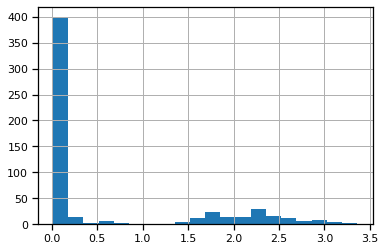

In [24]:
labels['redshift'].hist(bins=20)

In [27]:
label_dict = dict(zip(labels.index, labels['most_likely_rf_class'].values))
redshift_dict = dict(zip(labels.index, labels['redshift'].values))
# label_dict

In [29]:
for galaxy in galaxies:
    galaxy['rf_class'] = label_dict[int(galaxy['name'])]
    galaxy['spectro_z'] = redshift_dict[int(galaxy['name'])]

In [15]:
# galaxy_locs

### How do we do at reproducing observations?

In [16]:
# !scp -r -oProxyJump=mikewalmsley@aquila.star.bris.ac.uk mike@zeus.star.bris.ac.uk:/scratch/agnfinder/agnfinder/results/checkpoints/latest /home/mike/repos/agnfinder/results/checkpoints/latest

In [17]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)

In [18]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])



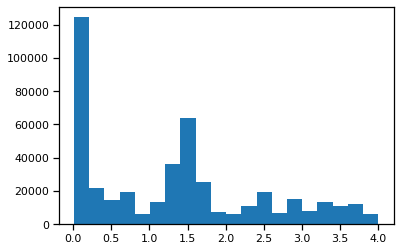

In [26]:
if 'redshift' not in params:
    redshifts = np.array([g['fixed_params'] for g in galaxies]).squeeze() * 4
else:
    redshifts = np.array([g['samples'][:, 0] for g in galaxies]).flatten() * 4
_ = plt.hist(redshifts, bins=20)

In [46]:
galaxy

{'samples': array([[0.16095084, 0.4166401 , 0.45238492, ..., 0.9998868 , 0.354202  ,
         0.26717567],
        [0.1611099 , 0.41680846, 0.45260662, ..., 0.9995842 , 0.35413718,
         0.26736495],
        [0.16098157, 0.4164093 , 0.4528342 , ..., 0.9996972 , 0.35515934,
         0.26617396],
        ...,
        [0.28841937, 0.59337205, 0.46014786, ..., 0.99773026, 0.34941298,
         0.25602546],
        [0.2887607 , 0.5931137 , 0.46005613, ..., 0.9980602 , 0.3491571 ,
         0.2559016 ],
        [0.2893423 , 0.5928943 , 0.4602899 , ..., 0.9972694 , 0.3493265 ,
         0.25528476]], dtype=float32),
 'name': '341',
 'true_observations': array([1.6667062e-08, 8.7708578e-08, 1.8534475e-07, 2.8404781e-07,
        3.9057804e-07, 6.6257888e-07, 5.1070742e-07, 6.8546439e-07,
        4.1308789e-07, 3.1819508e-07, 3.9247075e-07, 3.3862551e-07],
       dtype=float32),
 'uncertainty': array([3.60871666e-09, 2.63548938e-09, 4.20752366e-09, 6.19619556e-09,
        2.01801473e-08, 2.82086

In [47]:
redshift_comparison = [(np.median(g['samples'][:, 0]), g['spectro_z'], g['rf_class']) for g in galaxies]
redshift_df = pd.DataFrame(data=redshift_comparison, columns=['agnfinder', 'spectroscopy', 'rf_class'])

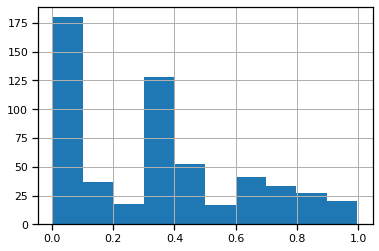

In [50]:
redshift_df['agnfinder'].hist()

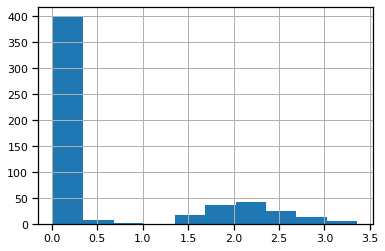

In [51]:
redshift_df['spectroscopy'].hist()

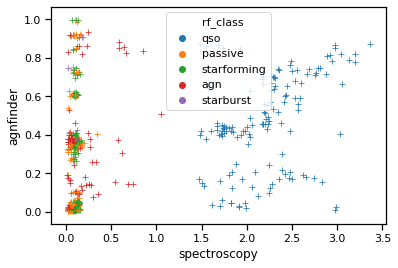

In [77]:
sns.scatterplot(data=redshift_df, x='spectroscopy', y='agnfinder', marker='+', hue='rf_class')

(0.0, 0.3)

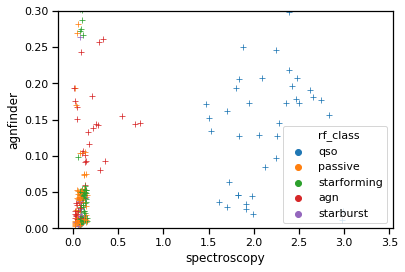

In [53]:
sns.scatterplot(data=redshift_df, x='spectroscopy', y='agnfinder', marker='+', hue='rf_class')
plt.ylim([0., 0.3])

In [ ]:
# theta = np.ones((1, 8)) * 0.5
# for z in np.linspace(0, .9, 10):
#     theta[:, 0] = z
#     plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+', label=z)
# plt.legend()

In [ ]:
# theta = np.ones((1, 8)) * 0.5
# for z in np.linspace(0, .9, 10):
#     theta[:, 1] = z
#     plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



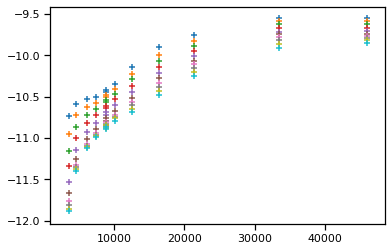

In [54]:
theta = np.ones((1, 9)) * 0.5
for z in np.linspace(0, .9, 10):
    theta[:, 2] = z
    plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')

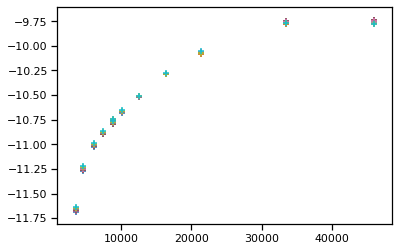

In [55]:
theta = np.ones((1, 9)) * 0.5
for z in np.linspace(0, .9, 10):
    theta[:, -1] = z
    plt.scatter(wavelengths, -np.squeeze(emulator(theta)), marker='+')

In [56]:
list(zip(np.log10(galaxy['true_observations']), np.log10(galaxy['uncertainty'] / 5.)))

[(-7.778141, -9.141617),
 (-7.0569577, -9.278109),
 (-6.73202, -9.074944),
 (-6.5466084, -8.906845),
 (-6.4082923, -8.394046),
 (-6.1787624, -8.248589),
 (-6.2918277, -8.315001),
 (-6.1640153, -8.162403),
 (-6.3839574, -8.444721),
 (-6.4973063, -8.697152),
 (-6.406193, -8.063408),
 (-6.47028, -8.060549)]

In [57]:
def plot_galaxy(galaxy, ax, emulator, wavelengths):
    true_photometry = galaxy['true_observations']
    if 'redshift' not in params:
        redshifts = np.array([galaxy['redshift'] for _ in range(len(galaxy['samples']))])
    #     print(redshifts.shape)
    #     print(galaxy['samples'].shape)
        input_params = np.concatenate((redshifts, galaxy['samples']), axis=1)
    #     print(params_with_redshift.shape)
    else:
        input_params = galaxy['samples']
    sample_photometry = deep_emulator.denormalise_photometry(emulator(input_params)).numpy()
    np.random.shuffle(sample_photometry)

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for trace in sample_photometry[:250]:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.02)
    ax.legend()
    ax.set_title('{} {}'.format(galaxy['rf_class'], galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

In [58]:
galaxy['rf_class']

'agn'

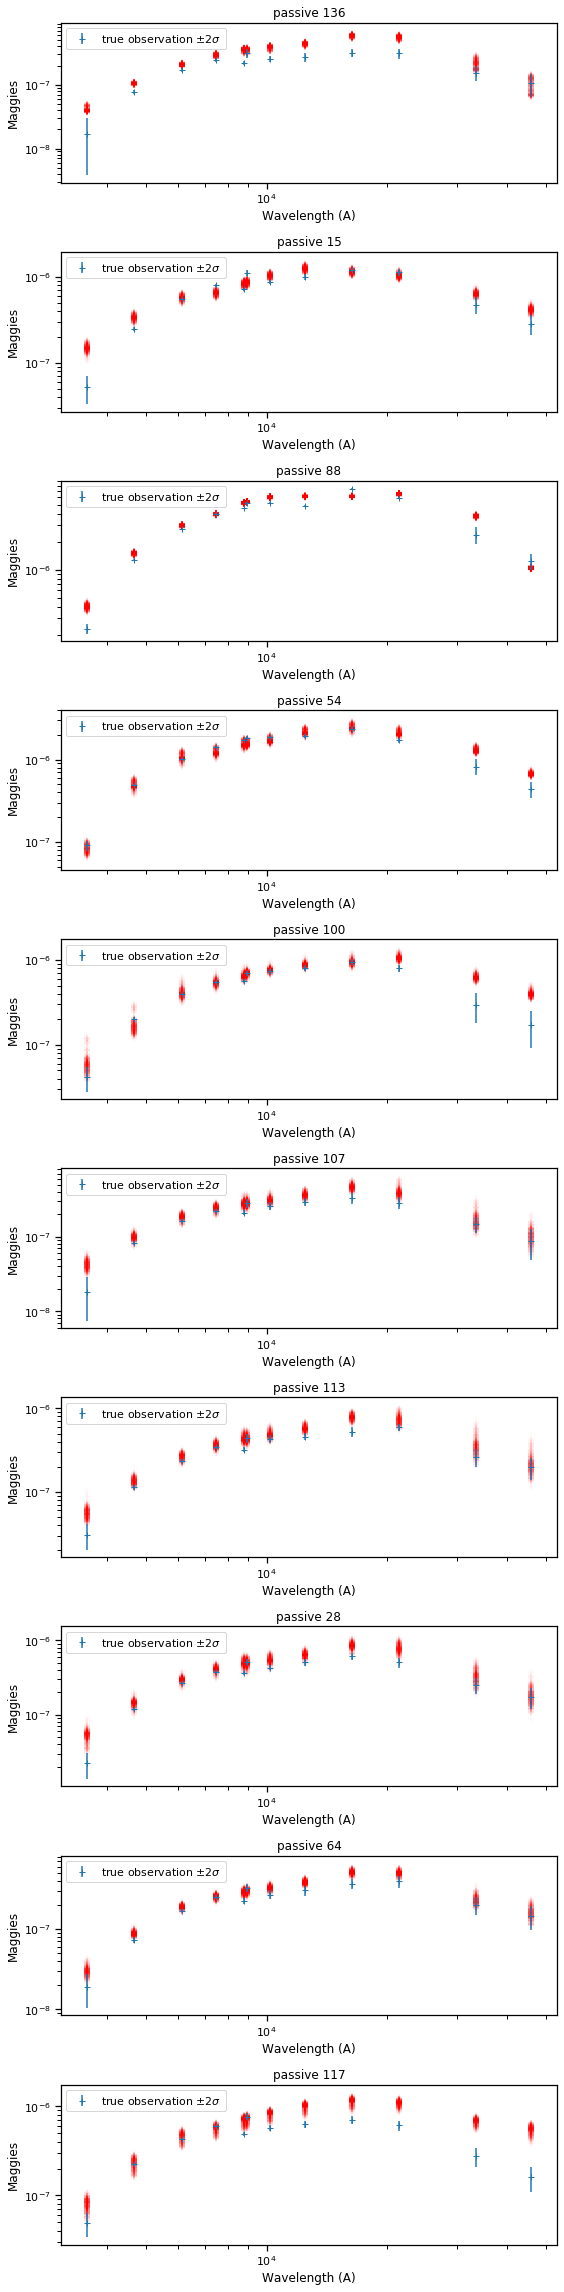

In [59]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

n = 0
for galaxy in galaxies:
    if galaxy['rf_class'] == 'passive':
        ax = axes[n]
        plot_galaxy(galaxy, ax, emulator, wavelengths)
        n += 1
    if n >= n_galaxies:
        break
plt.tight_layout()

In [61]:
galaxy['rf_class']

'passive'

In [62]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [63]:
raw_df.head()

,index,redshift,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,inclination,rf_class
0,0,0.835932,0.883265,0.031155,0.033520,0.502780,0.655135,0.225644,0.415591,0.416977,qso
1,1,0.778529,0.856794,0.058088,0.022601,0.498788,0.624487,0.215977,0.470499,0.285558,qso
2,2,0.799039,0.874340,0.036645,0.029606,0.560418,0.607871,0.248781,0.426676,0.308457,qso
3,3,0.793738,0.936188,0.080252,0.037196,0.782830,0.474532,0.267319,0.370574,0.335595,qso
4,4,0.855947,0.997060,0.050868,0.067061,0.767254,0.269375,0.321411,0.332078,0.288064,qso


In [64]:
len(raw_df)

442400

In [65]:
df = raw_df

In [66]:
df['rf_class']

0         qso
1         qso
2         qso
3         qso
4         qso
         ... 
442395    agn
442396    agn
442397    agn
442398    agn
442399    agn
Name: rf_class, Length: 442400, dtype: object

In [67]:
df[params].median()

redshift             0.338579
mass                 0.738094
dust2                0.312660
tage                 0.284590
tau                  0.403992
agn_disk_scaling     0.732154
agn_eb_v             0.522907
agn_torus_scaling    0.424725
inclination          0.492660
dtype: float32

In [68]:
(df[params] > 1e-3).shape

(442400, 9)

In [69]:
df = df[np.all(df[params] > 1e-3, axis=1)]
df = df[np.all(df[params] < .999, axis=1)]

In [70]:
df[params].min()

redshift             0.002565
mass                 0.001046
dust2                0.001000
tage                 0.001000
tau                  0.001000
agn_disk_scaling     0.001002
agn_eb_v             0.001011
agn_torus_scaling    0.001000
inclination          0.001001
dtype: float32

In [71]:
df[params].max()

redshift             0.998933
mass                 0.999000
dust2                0.998999
tage                 0.998995
tau                  0.998999
agn_disk_scaling     0.999000
agn_eb_v             0.999000
agn_torus_scaling    0.998981
inclination          0.998997
dtype: float32

In [72]:
# free_params = ['mass', 'dust2', 'tage', 'agn_eb_v', 'agn_torus_mass']
# log_params = ['mass', 'agn_mass', 'tau']

In [73]:
df['rf_class']

0         qso
1         qso
2         qso
3         qso
4         qso
         ... 
442392    agn
442393    agn
442394    agn
442395    agn
442396    agn
Name: rf_class, Length: 408197, dtype: object

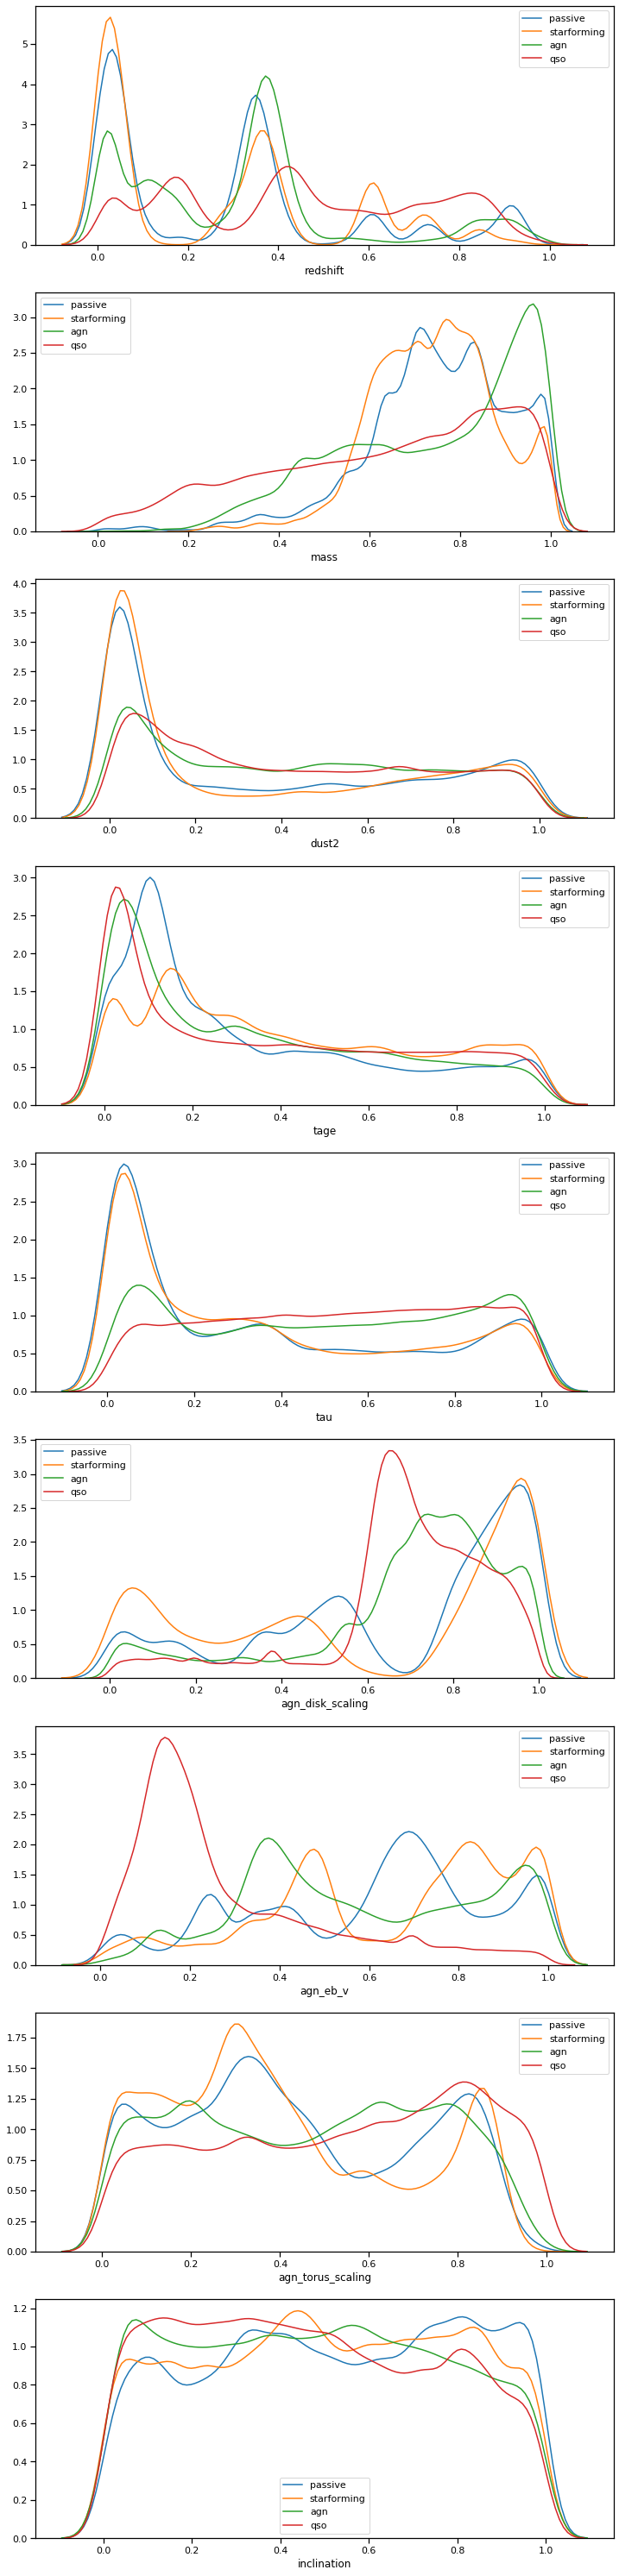

In [74]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in ['passive', 'starforming', 'agn', 'qso']:
        values = df[df['rf_class'] == galaxy_class][feature]
#         if feature in log_params:
#             values = np.log10(values)
#         print(values.shape)
        if len(values) > 0:
            sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')

In [ ]:
# df = df[df['rf_class'] != 'agn']

In [76]:
from agnfinder import simulation_utils
from collections import OrderedDict

# a bit hacky - log* keys will be 10 ** within simulator function below
free_params = OrderedDict({
    'redshift': [0., 4.],
    'log_mass': [8, 12], 
    'dust2': [0., 2.],  # not age of universe, as mistakenly done before...
    'tage': [0.001, 13.8],  # not 0->2, as mistakenly done before...might consider bringing the bounds a bit tighter
    'log_tau': [np.log10(.1), np.log10(30)],  # careful, this is log prior! >2, has very little effect
    'log_agn_mass': [-7, np.log10(15)],  # i.e. from 10**-7 to 15 (not 10**15!)
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})
param_dim = len(free_params.keys())


In [ ]:
df['dust2'].hist()

In [ ]:
for galaxy in galaxies:
    galaxy['denormalised_samples'] = simulation_utils.denormalise_theta(galaxy['samples'], free_params)

In [ ]:
galaxy['samples'][0]

In [ ]:
galaxy['denormalised_samples'][0]

In [ ]:
data = []
for galaxy in galaxies:
        temp_df = pd.DataFrame(galaxy['denormalised_samples'], columns=params)
        temp_df['rf_class'] = galaxy['rf_class']
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [ ]:
df = raw_df

In [ ]:
df[params].min()

In [ ]:
log_params = ['mass', 'tau', 'agn_disk_scaling', 'agn_torus_scaling']

In [ ]:
df['dust2'].hist()

In [ ]:
df = df.query('mass > 10 ** -5')  # a few masses are broken

In [ ]:
nrows = len(params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
#     for galaxy_class in rf_classes:
    for galaxy_class in ['passive', 'starforming', 'agn', 'qso']:
        values = df[df['rf_class'] == galaxy_class][feature]
        if feature in log_params:
            values = np.log10(values)
        if len(values) > 0:
            try:
                sns.distplot(values, label=galaxy_class, kde=True, hist=False, ax=ax)
            except ValueError:
                print('Failed {} {}'.format(feature, galaxy_class))
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')